!!Introduction

## Python Setup
Import the modules we will be using in our notebook

In [1]:
import datetime
import os
import sys
import time
import random
import json

from urllib.request import urlretrieve
import numpy as np
import pandas as pd

import boto3
import s3fs
import sagemaker
import matplotlib.pyplot as plt

In [3]:
!conda install -y -q s3fs
%run -i helper.py

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
url = "https://data.milwaukee.gov/dataset/5fafe01d-dc55-4a41-8760-8ae52f7855f1/resource/8fffaa3a-b500-4561-8898-78a424bdacee/download/trafficaccident.csv"
filename = "trafficaccident.csv"

In [5]:
if not os.path.isfile(filename):
    print("downloading dataset, can take a few minutes depending on your connection")
    urlretrieve(url, filename, reporthook=progress_report_hook)
else:
    print("File found skipping download")

File found skipping download


READ AND PARSE FILE

In [6]:
df = pd.read_csv(filename, sep=",", parse_dates=True, error_bad_lines=False)
df.index = pd.to_datetime(df['CASEDATE'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.drop(columns='CASEDATE')
df = df.drop(columns='CASENUMBER')
df = df.rename(columns={'ACCIDENTLOC':'count'})
df = df.resample('1H').count()
df = df['2008':]

## Data Visualization

### Graph Accidents Over Time

We will start with two simple line graphs. First graph will display the number of accidents over the entire set of data, allowing us to see trends spanning multiple years. Next the graph will overlay each year on one another, showing how years compare to one another as well as showing seasonality trends.

#### Steps

* First create a dataframe of the data we are going to plot. Since in the second graph we will be comparing years, we only want years with complete data. In this case it the years 2008 - 2018.

* Plot the dataframe. Resampling the dataframe will be necessary to show meaningful results. Expertiment with no resampling and by the hour, week, month, etc. 

* Next create a pivot table dataframe, with the month as the index and the yearas the columns. Aggregate using the sum function. 

* Plot the pivot dataframe.

* Use the plt.show() to output graph

#### Notes
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html  

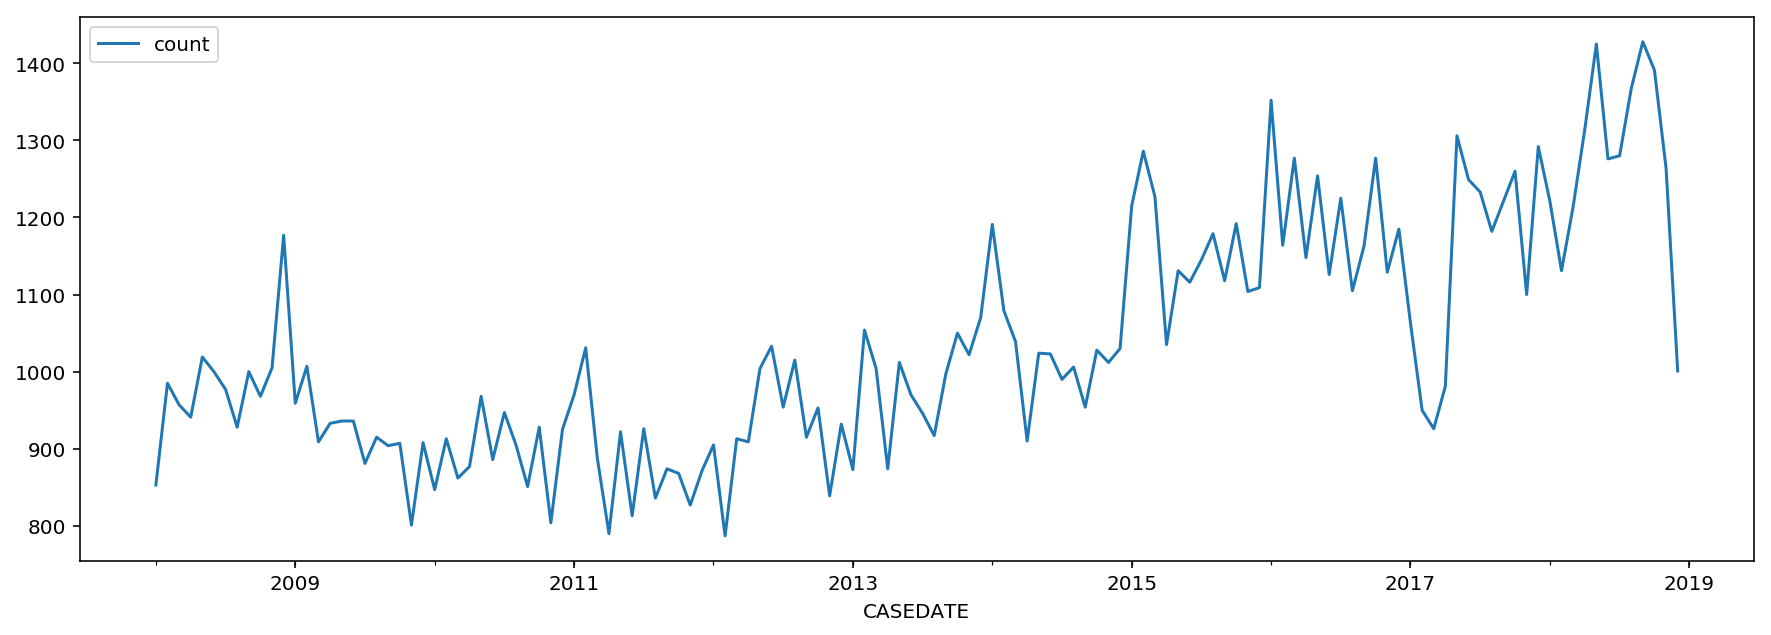

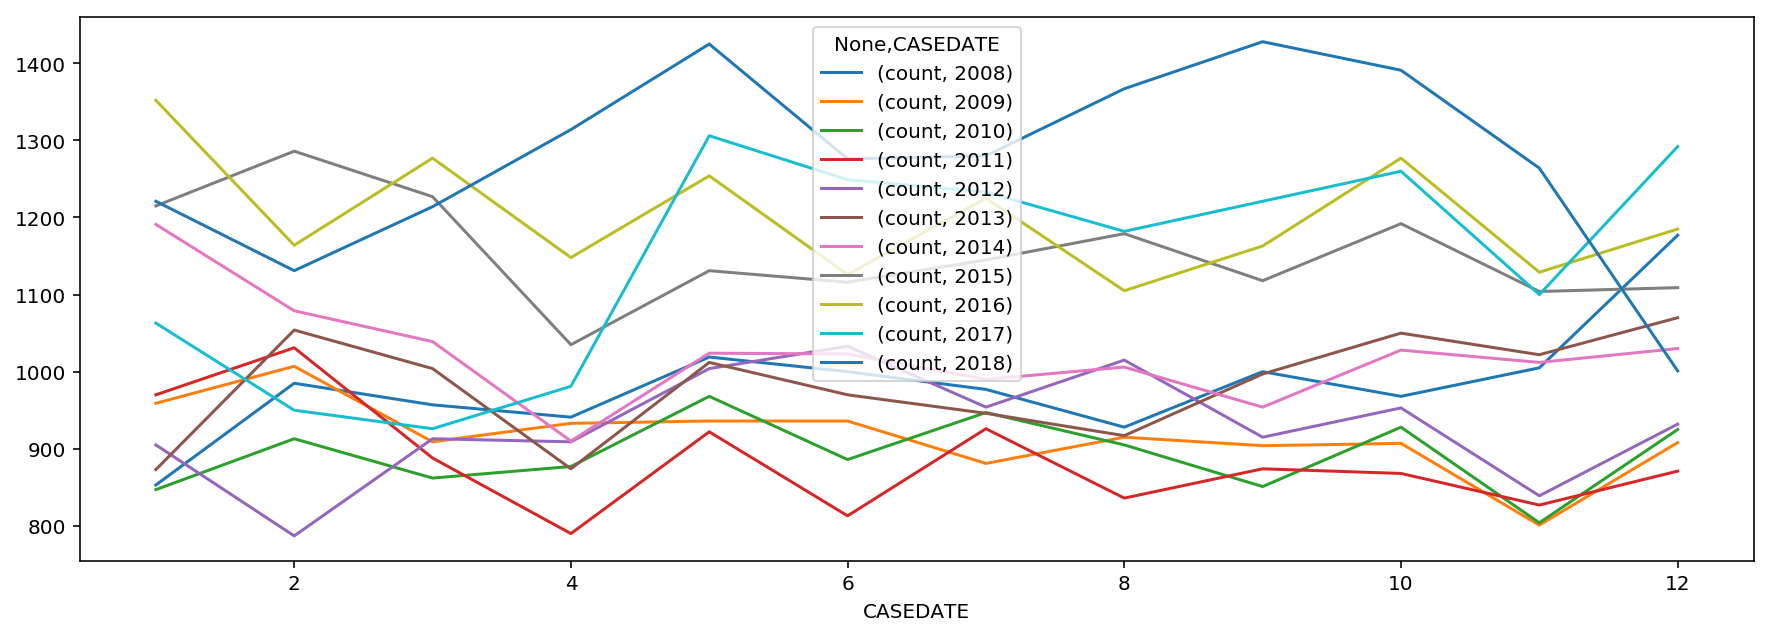

In [7]:
df_2008_2018 = df['2008':'2018']

df_2008_2018.resample('1M').sum().plot()

pd.pivot_table(
    df_2008_2018,
    index = df_2008_2018.index.month,
    columns = df_2008_2018.index.year,
    aggfunc = 'sum'
).plot()

plt.show()

### Histograms 



#### Steps
* First create a dataframe of your sample data.
* Next create a pivot table dataframe, with the day of the week as the index (y axis) and hour of the day as the column (x axis). Aggregate using the mean function. 
* Plot the pivot dataframe using the imshow function. 

#### Notes
Monday = 0  
Midnight - 1:00AM = 0  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html  
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html  
https://matplotlib.org/tutorials/colors/colormaps.html 

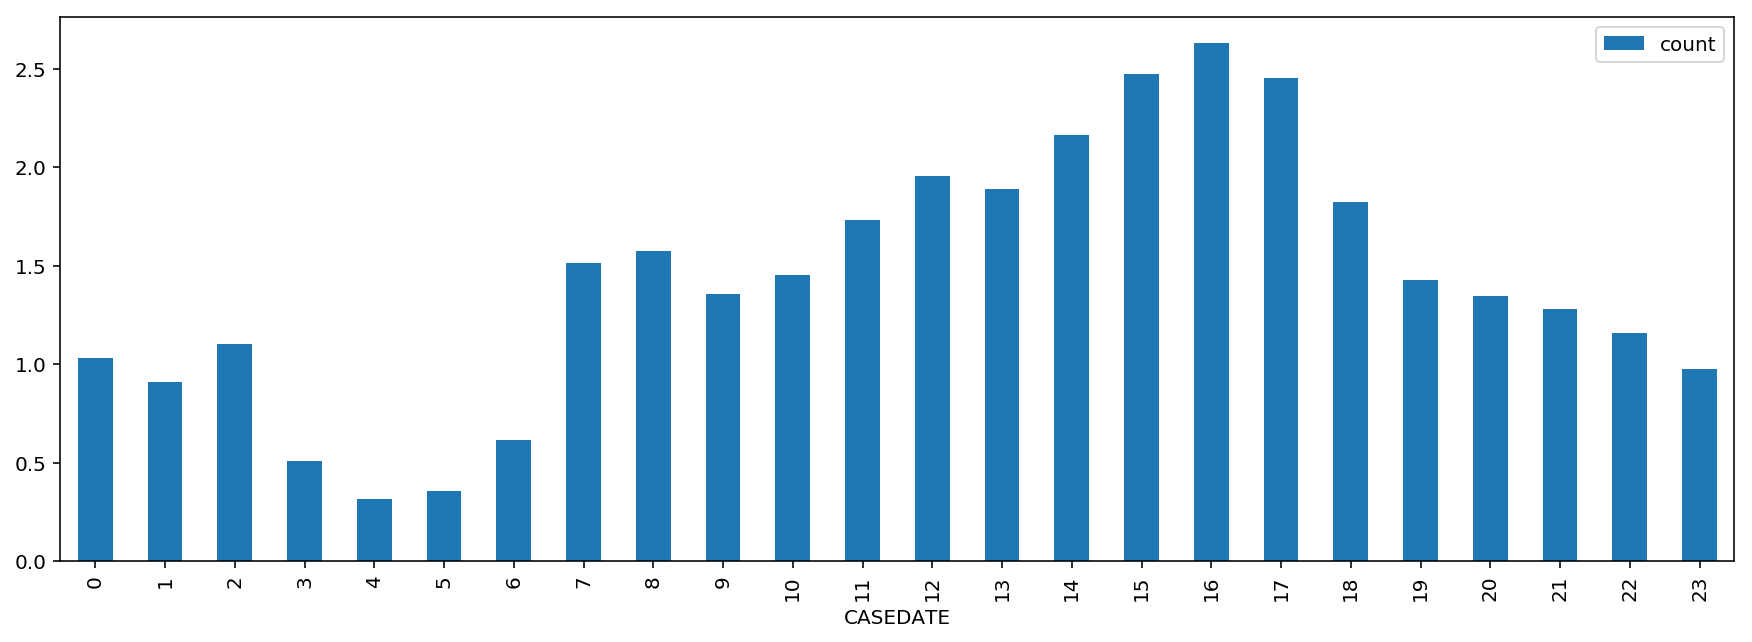

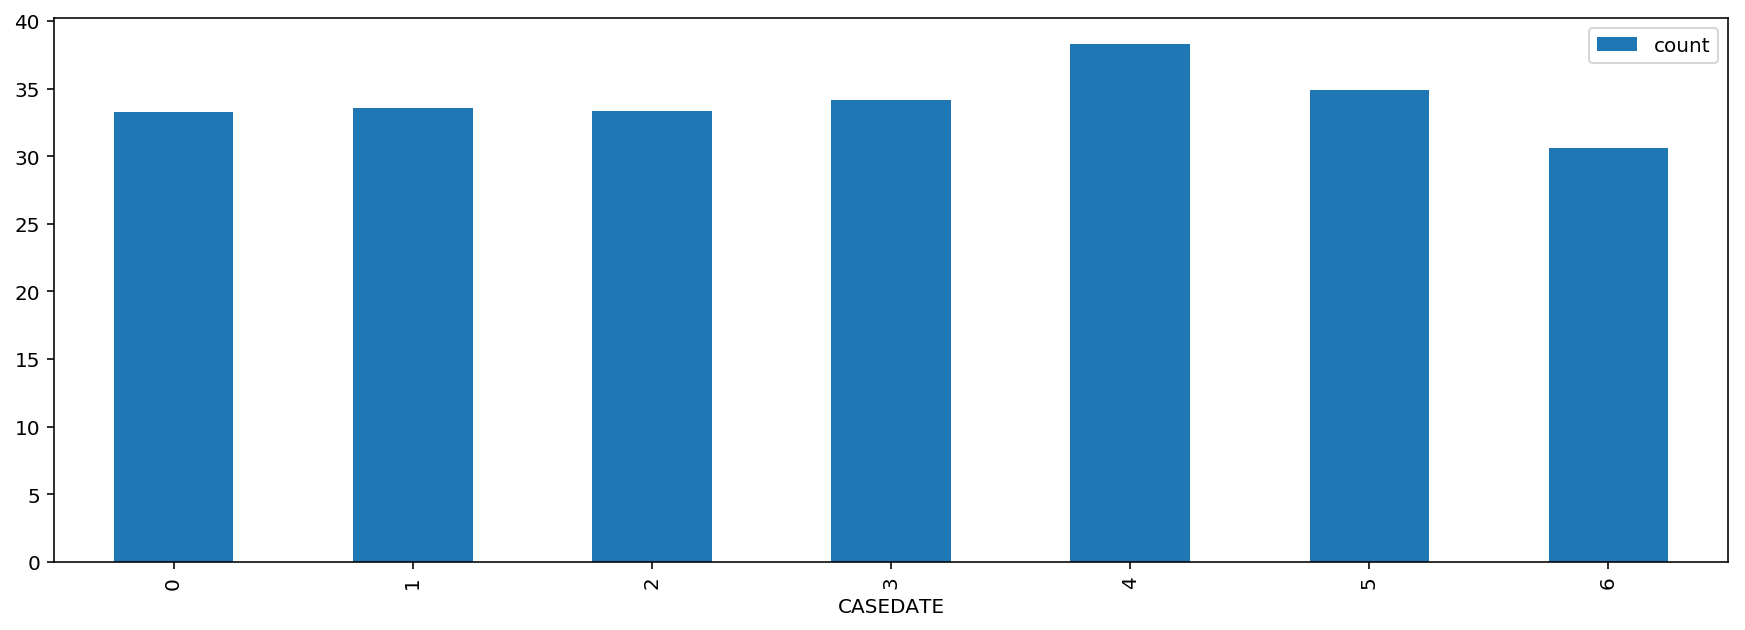

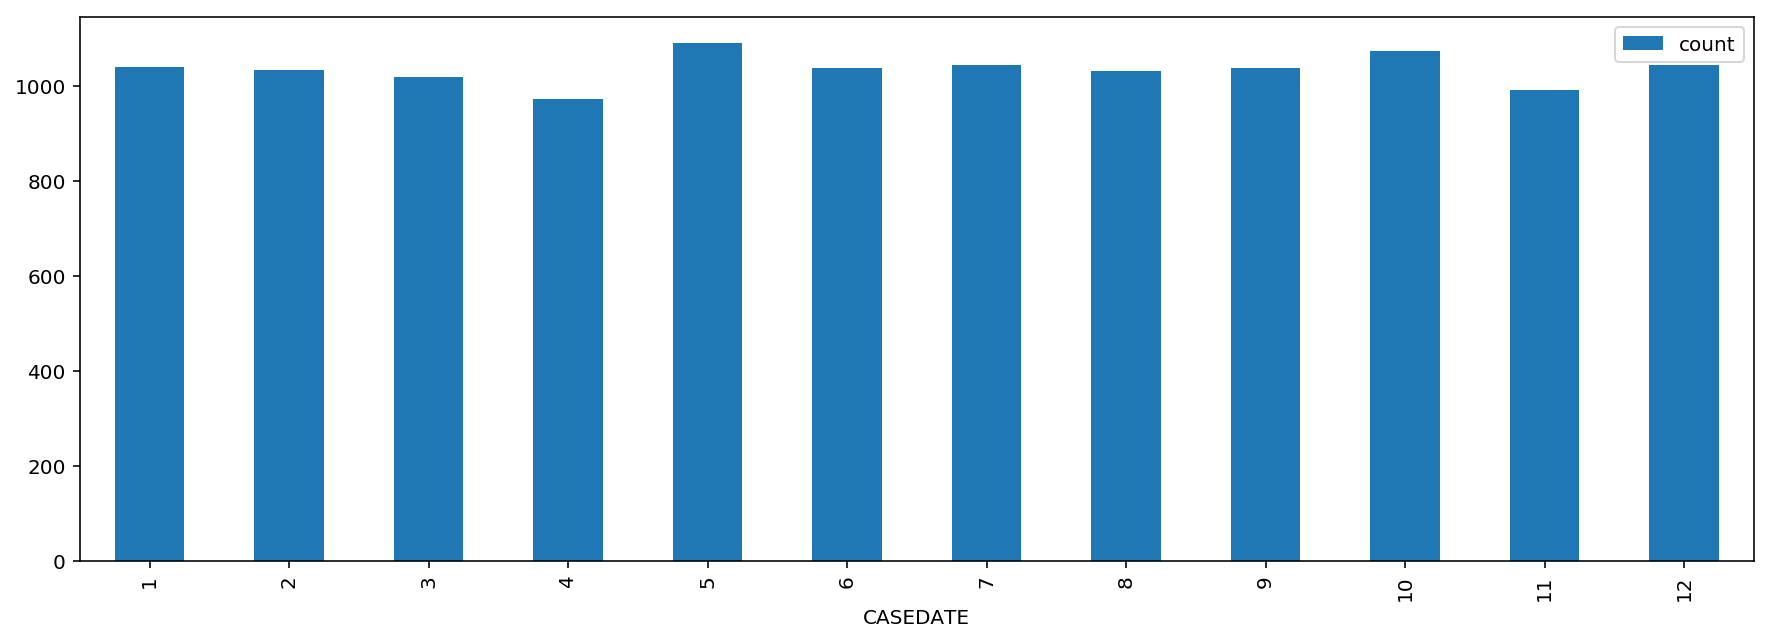

In [7]:
df_2008_2018.groupby(df_2008_2018.index.hour).mean().plot(kind="bar")

df_week = df_2008_2018.resample('1D').sum()
df_week.groupby(df_week.index.weekday).mean().plot(kind="bar")

df_month = df_2008_2018.resample('1M').sum()
df_month.groupby(df_month.index.month).mean().plot(kind="bar")

plt.show()

### Heatmap Graph
Let's create a heatmap, comparing the accidents that occur on each day of the week by hour. A heatmap displays the values of a maxtrix in a two dimentional representation.

#### Steps
* First create a dataframe of your sample data.
* Next create a pivot table dataframe, with the day of the week as the index (y axis) and hour of the day as the column (x axis). Aggregate using the mean function. 
* Plot the pivot dataframe as a heatmap using the imshow function. 

#### Notes
Monday = 0  
Midnight - 1:00AM = 0  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html  
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html  
https://matplotlib.org/tutorials/colors/colormaps.html  

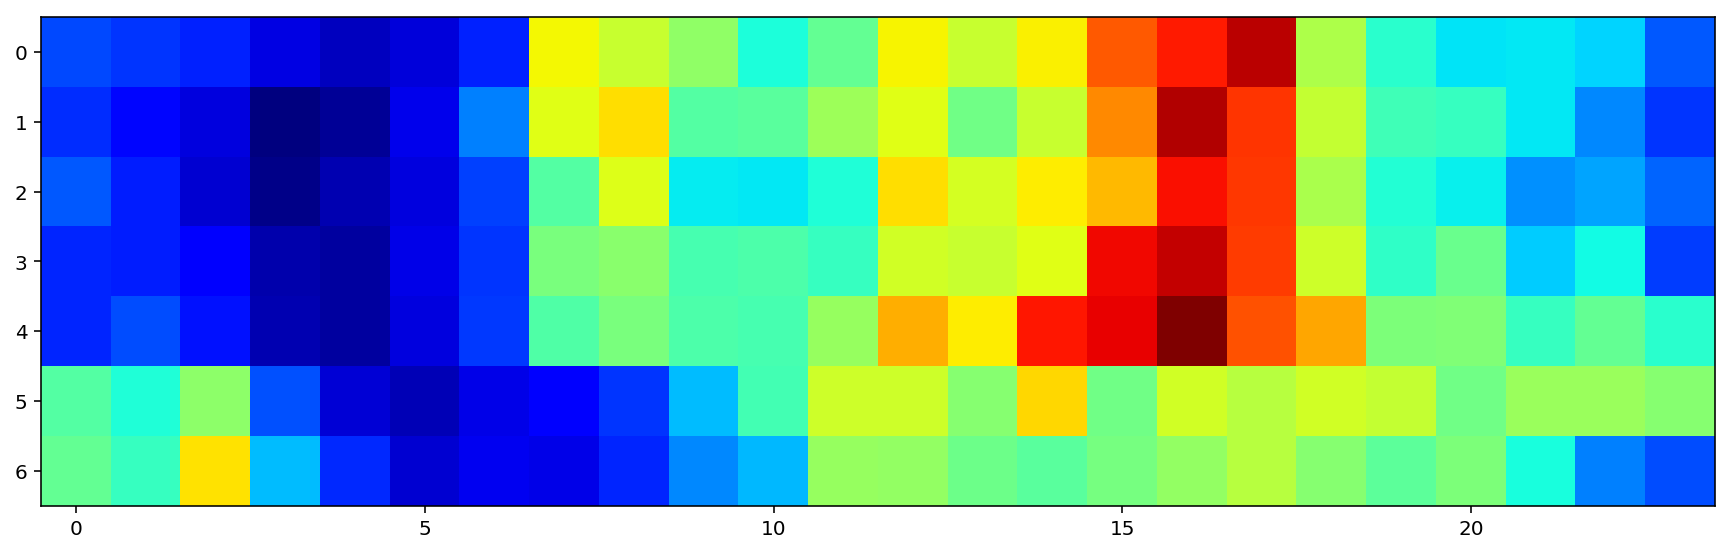

In [15]:
heatmap_dataframe = df['2018-01-01':'2018-12-31']
heatmap_pivot = pd.pivot_table(
    heatmap_dataframe, 
    index = heatmap_dataframe.index.weekday,
    columns = heatmap_dataframe.index.hour,
    aggfunc='mean')
#print(heatmap_pivot)

plt.figure(figsize=(15,5))
im = plt.imshow(heatmap_pivot,cmap='jet')
plt.show()

## Machine Learning 

### Sagemaker Setup

In [9]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:

The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [10]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-traffic-accident-notebook'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023630502738


In [11]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [12]:
freq = 'H'
prediction_length = 336 # 2 weeks (24 * 14)
context_length = 336

### Setup Test Data

In [13]:
time_series_training = []
time_series_training.append(df["2008":"2008"]['count'])
time_series_training.append(df["2009":"2009"]['count'])
time_series_training.append(df["2010":"2010"]['count'])
time_series_training.append(df["2011":"2011"]['count'])
time_series_training.append(df["2012":"2012"]['count'])
time_series_training.append(df["2013":"2013"]['count'])
time_series_training.append(df["2014":"2014"]['count'])
time_series_training.append(df["2015":"2015"]['count'])
time_series_training.append(df["2016":"2016"]['count'])
time_series_training.append(df["2017":"2017"]['count'])

time_series = []
time_series.append(df['2018':'2018']['count'])

### Write training and test data to S3

In [14]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### Configure DeepAR estimator training job

In [16]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path=s3_output_path
)

### Set Hyperparameters

Hyperparameters are parameters used for to configure machine learning algorthim, set are outside prior to the training process. Changing these parameters can have a dramatic impact on the accurary and performance of the model. That said, tuning most of these hyperparameters is outside the scope of this workshop. The relevant hyperparameters are as follows:

 * **time_freq** - The target frequency interval of the data. Hourly in this example.
 * **context_length** - How far in the past DeepAR's network can see. Higher values may result in more accuracy at the expense of training time and expense, and computing resources to execute model.
 * **prediction_length** - How far in the future DeepAR's network can predict. Like **context_length**, higher values are more taxing during model training and execution. 

#### Notes
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html  

In [17]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "55",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "40",
    "mini_batch_size": "33",
    "learning_rate": "0.00256",
    "dropout_rate": "0.045",
    "early_stopping_patience": "10"
}
estimator.set_hyperparameters(**hyperparameters)

### Run DeepAR estimator job

In [18]:
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-04-24-20-59-58-922


2019-04-24 20:59:59 Starting - Starting the training job...
2019-04-24 21:00:01 Starting - Launching requested ML instances.........
2019-04-24 21:01:42 Starting - Preparing the instances for training...
2019-04-24 21:02:26 Downloading - Downloading input data...
2019-04-24 21:02:33 Training - Downloading the training image.....
Arguments: train
[04/24/2019 21:03:41 INFO 139763863426880] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/24/2019 21:

[04/24/2019 21:04:46 INFO 139763863426880] Epoch[2] Batch[10] avg_epoch_loss=1.684608
[04/24/2019 21:04:46 INFO 139763863426880] #quality_metric: host=algo-1, epoch=2, batch=10 train loss <loss>=1.66383130623
[04/24/2019 21:04:46 INFO 139763863426880] Epoch[2] Batch [10]#011Speed: 52.59 samples/sec#011loss=1.663831
[04/24/2019 21:04:46 INFO 139763863426880] processed a total of 331 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7106.698989868164, "sum": 7106.698989868164, "min": 7106.698989868164}}, "EndTime": 1556139886.021417, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556139878.914638}

[04/24/2019 21:04:46 INFO 139763863426880] #throughput_metric: host=algo-1, train throughput=46.5749075171 records/second
[04/24/2019 21:04:46 INFO 139763863426880] #progress_metric: host=algo-1, completed 7 % of epochs
[04/24/2019 21:04:46 INFO 139763863426880] #quality_metric: host=algo-1, epoch=2, train loss <loss>=1.68460

[04/24/2019 21:05:20 INFO 139763863426880] processed a total of 308 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6514.682054519653, "sum": 6514.682054519653, "min": 6514.682054519653}}, "EndTime": 1556139920.03256, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556139913.517381}

[04/24/2019 21:05:20 INFO 139763863426880] #throughput_metric: host=algo-1, train throughput=47.2767577619 records/second
[04/24/2019 21:05:20 INFO 139763863426880] #progress_metric: host=algo-1, completed 20 % of epochs
[04/24/2019 21:05:20 INFO 139763863426880] #quality_metric: host=algo-1, epoch=7, train loss <loss>=1.59338689862
[04/24/2019 21:05:20 INFO 139763863426880] best epoch loss so far
[04/24/2019 21:05:20 INFO 139763863426880] Saved checkpoint to "/opt/ml/model/state_14408e37-abbb-4d59-a58b-c9f439b05499-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 230.6361198425293, "sum": 230.6361198425293,

[04/24/2019 21:06:01 INFO 139763863426880] processed a total of 314 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6475.152969360352, "sum": 6475.152969360352, "min": 6475.152969360352}}, "EndTime": 1556139961.692667, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556139955.217433}

[04/24/2019 21:06:01 INFO 139763863426880] #throughput_metric: host=algo-1, train throughput=48.4920201313 records/second
[04/24/2019 21:06:01 INFO 139763863426880] #progress_metric: host=algo-1, completed 35 % of epochs
[04/24/2019 21:06:01 INFO 139763863426880] #quality_metric: host=algo-1, epoch=13, train loss <loss>=1.59648333463
[04/24/2019 21:06:01 INFO 139763863426880] loss did not improve
[04/24/2019 21:06:02 INFO 139763863426880] Epoch[14] Batch[0] avg_epoch_loss=1.599192
[04/24/2019 21:06:02 INFO 139763863426880] #quality_metric: host=algo-1, epoch=14, batch=0 train loss <loss>=1.59919241703
[04/24/2019 21:06:05 INFO 139763863

[04/24/2019 21:06:42 INFO 139763863426880] processed a total of 323 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6509.5319747924805, "sum": 6509.5319747924805, "min": 6509.5319747924805}}, "EndTime": 1556140002.745886, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556139996.235755}

[04/24/2019 21:06:42 INFO 139763863426880] #throughput_metric: host=algo-1, train throughput=49.618499586 records/second
[04/24/2019 21:06:42 INFO 139763863426880] #progress_metric: host=algo-1, completed 50 % of epochs
[04/24/2019 21:06:42 INFO 139763863426880] #quality_metric: host=algo-1, epoch=19, train loss <loss>=1.57740573305
[04/24/2019 21:06:42 INFO 139763863426880] loss did not improve
[04/24/2019 21:06:43 INFO 139763863426880] Epoch[20] Batch[0] avg_epoch_loss=1.565028
[04/24/2019 21:06:43 INFO 139763863426880] #quality_metric: host=algo-1, epoch=20, batch=0 train loss <loss>=1.56502845071
[04/24/2019 21:06:46 INFO 1397638

[04/24/2019 21:07:22 INFO 139763863426880] processed a total of 330 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6487.972021102905, "sum": 6487.972021102905, "min": 6487.972021102905}}, "EndTime": 1556140042.069548, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556140035.581505}

[04/24/2019 21:07:22 INFO 139763863426880] #throughput_metric: host=algo-1, train throughput=50.8623176796 records/second
[04/24/2019 21:07:22 INFO 139763863426880] #progress_metric: host=algo-1, completed 65 % of epochs
[04/24/2019 21:07:22 INFO 139763863426880] #quality_metric: host=algo-1, epoch=25, train loss <loss>=1.56598698009
[04/24/2019 21:07:22 INFO 139763863426880] loss did not improve
[04/24/2019 21:07:22 INFO 139763863426880] Epoch[26] Batch[0] avg_epoch_loss=1.584207
[04/24/2019 21:07:22 INFO 139763863426880] #quality_metric: host=algo-1, epoch=26, batch=0 train loss <loss>=1.58420736139
[04/24/2019 21:07:26 INFO 139763863

[04/24/2019 21:08:01 INFO 139763863426880] processed a total of 308 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6447.036027908325, "sum": 6447.036027908325, "min": 6447.036027908325}}, "EndTime": 1556140081.661974, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556140075.214441}

[04/24/2019 21:08:01 INFO 139763863426880] #throughput_metric: host=algo-1, train throughput=47.7728403652 records/second
[04/24/2019 21:08:01 INFO 139763863426880] #progress_metric: host=algo-1, completed 80 % of epochs
[04/24/2019 21:08:01 INFO 139763863426880] #quality_metric: host=algo-1, epoch=31, train loss <loss>=1.57108548482
[04/24/2019 21:08:01 INFO 139763863426880] loss did not improve
[04/24/2019 21:08:02 INFO 139763863426880] Epoch[32] Batch[0] avg_epoch_loss=1.542206
[04/24/2019 21:08:02 INFO 139763863426880] #quality_metric: host=algo-1, epoch=32, batch=0 train loss <loss>=1.54220638853
[04/24/2019 21:08:05 INFO 139763863

[04/24/2019 21:08:43 INFO 139763863426880] Epoch[37] Batch[10] avg_epoch_loss=1.558549
[04/24/2019 21:08:43 INFO 139763863426880] #quality_metric: host=algo-1, epoch=37, batch=10 train loss <loss>=1.55221430461
[04/24/2019 21:08:43 INFO 139763863426880] Epoch[37] Batch [10]#011Speed: 52.18 samples/sec#011loss=1.552214
[04/24/2019 21:08:43 INFO 139763863426880] processed a total of 338 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7180.67479133606, "sum": 7180.67479133606, "min": 7180.67479133606}}, "EndTime": 1556140123.011085, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556140115.829973}

[04/24/2019 21:08:43 INFO 139763863426880] #throughput_metric: host=algo-1, train throughput=47.0699567903 records/second
[04/24/2019 21:08:43 INFO 139763863426880] #progress_metric: host=algo-1, completed 95 % of epochs
[04/24/2019 21:08:43 INFO 139763863426880] #quality_metric: host=algo-1, epoch=37, train loss <loss>=1.558

### Start Trained DeepAR Model Endpoint

In [19]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-04-24-20-59-58-922
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-04-24-20-59-58-922
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-04-24-20-59-58-922


----------------------------------------------------------------------------------------!

In [20]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [21]:
#time_series_predict_index = pd.DatetimeIndex(start='2018-06-28 06:00:000', freq='H', periods=prediction_length)
#time_series_predict = []
#time_series_predict.append(pd.Series(data=0, index=time_series_predict_index))
#time_series_predict
time_series_predict = [time_series_training[9].asfreq('H')]

In [22]:
list_of_prediction_dataframes = predictor.predict(time_series_predict, quantiles=["0.1", "0.5", "0.9"])

In [23]:
list_of_prediction_dataframes

[                          0.1       0.5       0.9
 2018-01-01 00:00:00 -0.641390  0.984004  2.480426
 2018-01-01 01:00:00 -0.320164  0.906120  1.963637
 2018-01-01 02:00:00 -0.676444  0.559467  1.900088
 2018-01-01 03:00:00 -0.790269  0.266035  1.392100
 2018-01-01 04:00:00 -0.611652  0.060366  0.882075
 2018-01-01 05:00:00 -0.447561  0.210297  0.978193
 2018-01-01 06:00:00 -0.173330  1.107135  2.364117
 2018-01-01 07:00:00  0.088725  2.023174  3.878324
 2018-01-01 08:00:00  0.331706  2.864699  4.964097
 2018-01-01 09:00:00  0.271476  2.589160  4.993111
 2018-01-01 10:00:00  0.231873  2.136256  5.097303
 2018-01-01 11:00:00  0.151710  2.458560  4.953113
 2018-01-01 12:00:00  0.252040  3.043409  4.822523
 2018-01-01 13:00:00  1.059767  3.115897  5.684113
 2018-01-01 14:00:00 -0.328307  2.746624  5.585182
 2018-01-01 15:00:00  0.659273  2.766416  6.073677
 2018-01-01 16:00:00  0.348263  3.003937  5.098238
 2018-01-01 17:00:00  0.773450  3.125719  5.351361
 2018-01-01 18:00:00  0.516793 

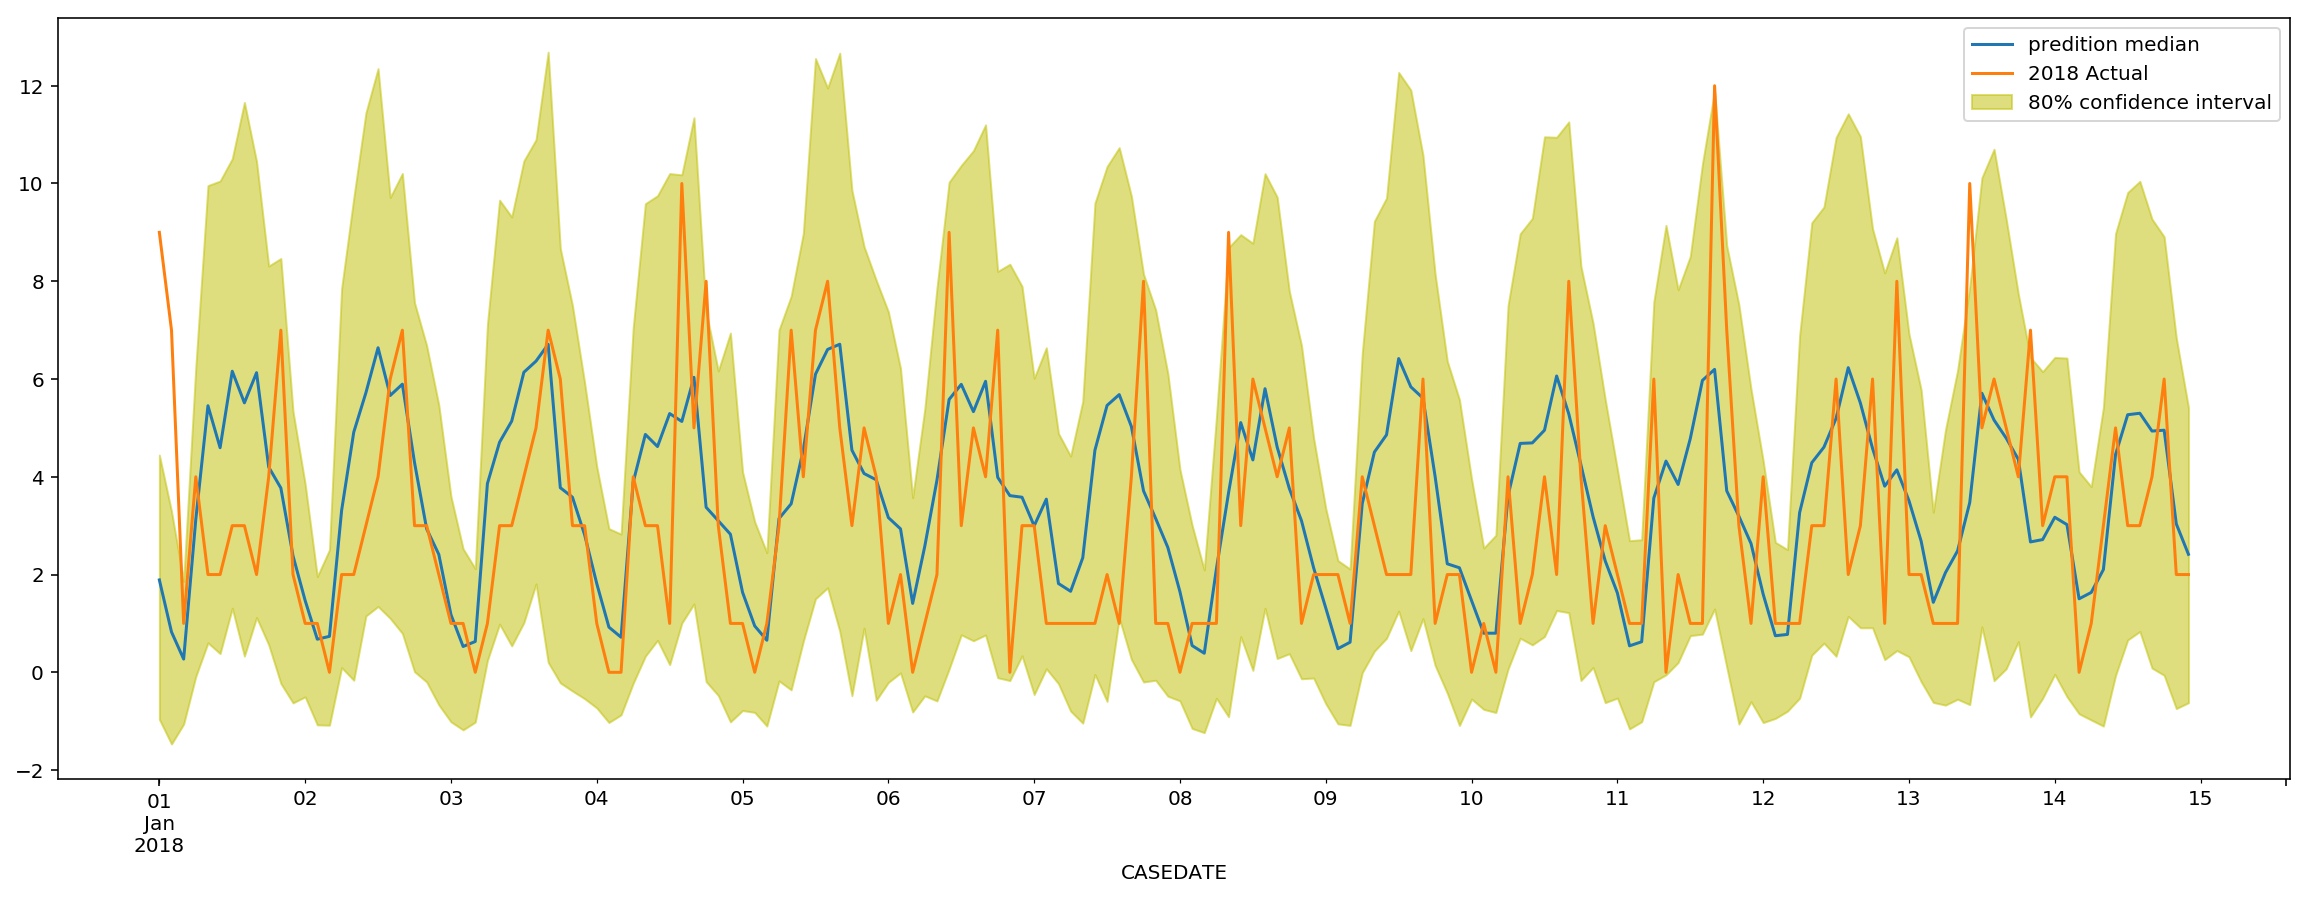

In [24]:
#parameters for time resolution and range to play
plot_interval = '2h'
plot_slice = slice('2018-01-01','2018-01-14')

#Create dataframes and series to plot
toplot_dataframe = list_of_prediction_dataframes[0][plot_slice].resample(plot_interval).sum()
toplotmedian = toplot_dataframe['0.5']
toplot10 = toplot_dataframe['0.1']
toplot90 = toplot_dataframe['0.9']

plt.figure(figsize=(20,7))

#Plot median line and 80% confidence interval area
toplotmedian.plot(label='predition median')
plt.fill_between(toplot10.index, toplot10, toplot90, color='y', alpha=.5, label='80% confidence interval')

#Create and plot actual data series
actual_data_series = time_series[0][plot_slice].resample(plot_interval).sum()
actual_data_series.plot(label='2018 Actual')


plt.legend()
plt.show()

In [25]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-04-24-20-59-58-922
